In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib_venn import venn3, venn2
from matplotlib.patches import Patch
from hydra import initialize, compose
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.standardize import standardize_smiles
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import SVG
from tqdm import tqdm
from minedatabase.pickaxe import Pickaxe
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
from functools import lru_cache

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

def make_venn2(left: set, right: set, left_name: str, right_name: str, left_color: tuple = (0,0,1,1), right_color: tuple = (1,0,0,1), do_save: bool = False):
    Ab = len(left - right)
    aB = len(right - left)
    AB = len(left & right)
    plt.figure()
    v = venn2(subsets = (Ab, aB, AB), set_labels = (left_name, right_name))
    v.get_patch_by_id('10').set_color(left_color)
    v.get_patch_by_id('01').set_color(right_color)

    plt.tight_layout()
    if do_save:
        plt.savefig(Path(cfg.figures) / f"{left_name.replace(' ','_')}_vs_{right_name.replace(' ','_')}_venn2.svg", format="svg")
    plt.show()

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

In [2]:
starters_name = "250728_benchmark_starters"
expansion_name = f"2_steps_{starters_name}"
a_plus_b = True
rule_sets = [
    'mechinformed',
    'mechinferred_dt_956',
    'mechinferred_dt_224',
    'mechinferred_dt_112',
    'mechinferred_dt_039',
    'mechinferred_dt_019',
    'rc_plus_1',
]

known_reactions = {}

for rule_set in rule_sets:
    fn = Path(cfg.raw_data) / f"mapped_known_reactions_x_{rule_set}_rules.parquet"
    print(fn)
    mapped_rxns = pd.read_parquet(fn)
    rxns = set(mapped_rxns["smarts"])
    known_reactions[rule_set] = rxns
    del mapped_rxns

ds = 10
dfes = []
for p in Path(cfg.processed_data).glob(f"*{expansion_name}*aplusb_{a_plus_b}*reaction_metrics.parquet"):
    rule_set = str(p.stem).split("_rules_")[1]
    if rule_set not in rule_sets:
        continue
   
    df = pd.read_parquet(p)
    df['rule_set'] = rule_set
    dfes.append(df)

rxn_df = pd.concat(dfes, ignore_index=True)
del dfes, df

print(len(rxn_df))
rxn_df["known"] = rxn_df.apply(
    lambda row: row["smarts"] in known_reactions[row["rule_set"]],
    axis=1
)
rxn_df = rxn_df[~rxn_df["known"]]
rxn_df = rxn_df.explode("rules")
rxn_df['rules'] = rxn_df['rules'].apply(lambda x : x.split('_')[0])
rxn_df['rules'] = rxn_df.apply(lambda row : f"{row['rule_set']}_rule_{row['rules']}", axis=1)
print(len(rxn_df))
rxn_df.head()

/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinformed_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_956_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_224_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_112_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_039_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_019_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_1_rules.parquet
730280
919977


,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,rule_set,known
0,R35e196dd0cbbbb3e8e9d0d6de5072659d71e89fd167a2...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,0.900000,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,2cdec316ece01e7bc421cee6847fef5284fb3e25,mechinferred_dt_956_rule_72,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False
1,R4444c69647517c3fde72a45e9ed7c8b693fa62ac9d0e0...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,1,0.927105,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,2f348cb02270404e553309450ac1b208a96282b7,mechinferred_dt_956_rule_72,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False
4,Rf5d0fe1092f5b5ef9b7450777a16b2396dd436284e4a2...,OCC(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O...,[OH:1][CH2:2][CH:3]([OH:4])[CH2:5][OH:6].[NH2:...,1,0.900000,O=C(O)C(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=...,b57572862476f442f14c90b02cf3695f0fc54762,mechinferred_dt_956_rule_209,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False
4,Rf5d0fe1092f5b5ef9b7450777a16b2396dd436284e4a2...,OCC(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O...,[OH:1][CH2:2][CH:3]([OH:4])[CH2:5][OH:6].[NH2:...,1,0.900000,O=C(O)C(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=...,b57572862476f442f14c90b02cf3695f0fc54762,mechinferred_dt_956_rule_2730,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False
6,Rec6d7525917f77e5f6c7a5942c1b7197b67be650c7476...,O=C(O)CCC(=O)O.O=C(O)CCC(=O)O>>O.O=C(O)CCC(=O)...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,0,0.710047,O=C(O)CCC(=O)O.CCCCCCCCCCCCCCCCOCC(O)COP(=O)(O...,4cd0fad17eb2966d09b5636f489e8ca1e32ca941,mechinferred_dt_956_rule_155,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False


In [3]:
known_reactions.keys()

dict_keys(['mechinformed', 'mechinferred_dt_956', 'mechinferred_dt_224', 'mechinferred_dt_112', 'mechinferred_dt_039', 'mechinferred_dt_019', 'rc_plus_1'])

In [4]:
kcs = pd.read_parquet(Path(cfg.raw_data) / "known_compounds.parquet")
kcs.head()

,id,smiles,name,chebi_id,n_atoms
0,df58248c414f342c81e056b40bee12d17a08bf61,*,A,CHEBI:13193,1
1,bc2f74c22f98f7b6ffbc2f67453dbfa99bce9a32,**,RX,CHEBI:17792,2
2,e8ecd17bfc980925ff0b634bd13104c09dc4591f,*C,an alkane,CHEBI:18310,2
3,b219689f21c828e7f057ef453af1187baa98fbf3,*C#N,a nitrile,CHEBI:18379,3
4,94295b0379859ca57b86c85b0768526c711fe762,*C(*)(O)C(*)(*)O,an ethanediol,CHEBI:140594,8


In [5]:
starters = pd.read_csv(Path(cfg.artifacts) / "starters" / "250728_benchmark_starters.csv")
starters['smiles'] = starters['smiles'].apply(standardize_smiles)
starters.head()

,id,smiles
0,succinate,O=C(O)CCC(=O)O
1,glycerol,OCC(O)CO
2,xylose,OC1COC(O)C(O)C1O
3,prephenic_acid,O=C(O)C(=O)CC1(C(=O)O)C=CC(O)C=C1
4,protocatechuic_acid,O=C(O)c1ccc(O)c(O)c1


In [6]:
template_sizes = pd.read_csv(
    Path(cfg.processed_data) / "template_size_stats.csv"
)
template_sizes.head(10)

,name,min,25%,median,mean,75%,max
0,mechinferred_dt_956_rules,3,3.0,4.0,5.501385,7.0,15
1,mechinferred_dt_224_rules,3,5.0,9.0,9.293601,13.0,30
2,mechinferred_dt_112_rules,3,7.0,11.0,12.484241,16.0,70
3,mechinferred_dt_039_rules,3,9.0,14.5,17.270657,20.0,133
4,mechinferred_dt_019_rules,3,12.0,24.0,26.119228,35.0,172
5,rc_plus_0_rules,3,4.0,6.0,6.695736,9.0,15
6,rc_plus_1_rules,3,6.0,8.0,8.889249,12.0,31
7,rc_plus_2_rules,3,10.0,12.0,13.415592,17.0,35
8,rc_plus_3_rules,3,12.0,16.0,17.150463,22.0,44
9,rc_plus_4_rules,3,14.0,21.0,20.757402,27.0,51


In [7]:
exp_labels = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': "Mechinformed",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_956_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.956",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_224_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.224",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_112_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.112",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_039_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.039",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_019_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.019",
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': "RC + 0",
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': "RC + 1",
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': "RC + 2",
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': "RC + 3",
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': "RC + 4",
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': "Pathway-level clustering",
    '2_steps_250728_benchmark_starters_rules_rdchiral_rules_w_coreactants_aplusb_True.pk': "RDChiral",
}

colors = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("green"),
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_956_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_224_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_112_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_039_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_019_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("darkorange"),
    '2_steps_250728_benchmark_starters_rules_rdchiral_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("blue"),
}

exp_names = list(exp_labels.keys())

legend_elements = [
    Patch(facecolor=col, edgecolor='w', label=exp_labels[name])
    for name, col in colors.items()
]

In [8]:
rids = {}
for exp_name, short_name in exp_labels.items():
    rids[short_name] = set(rxn_df.loc[rxn_df["expansion"] == exp_name, "id"].values)

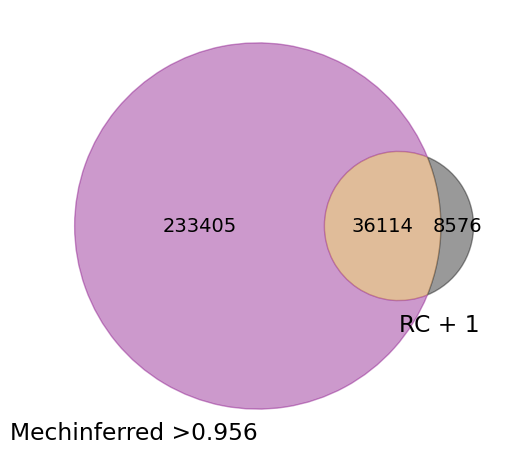

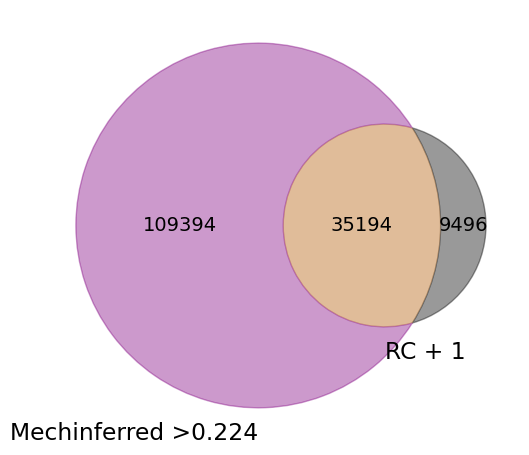

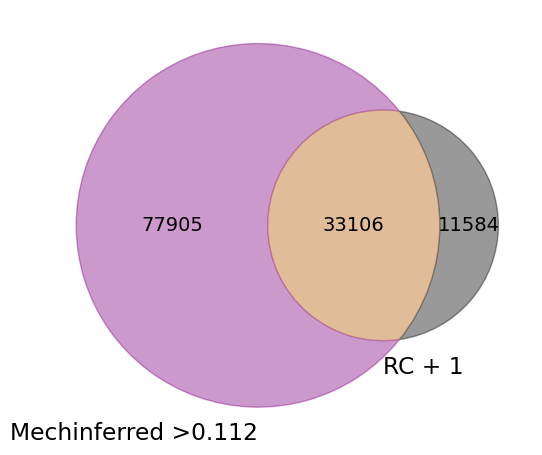

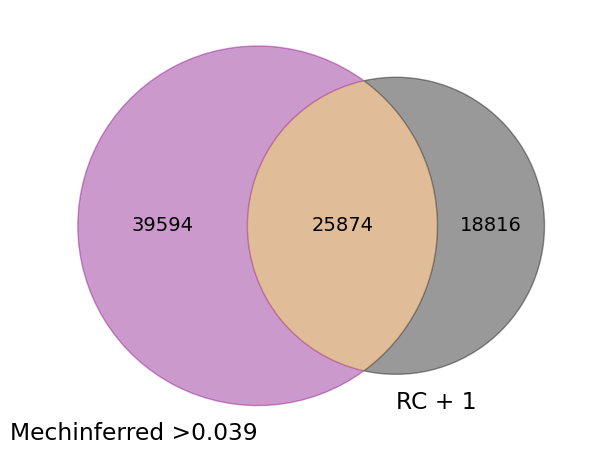

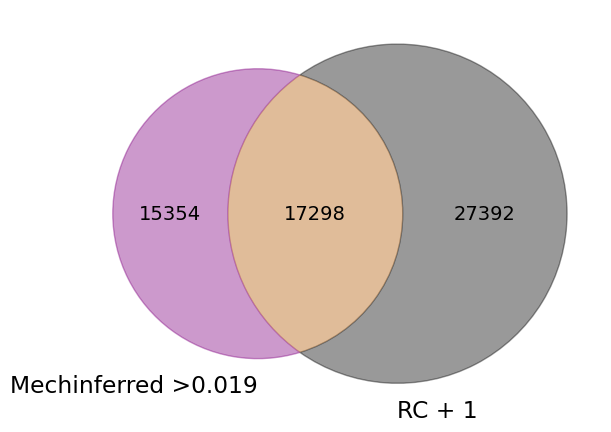

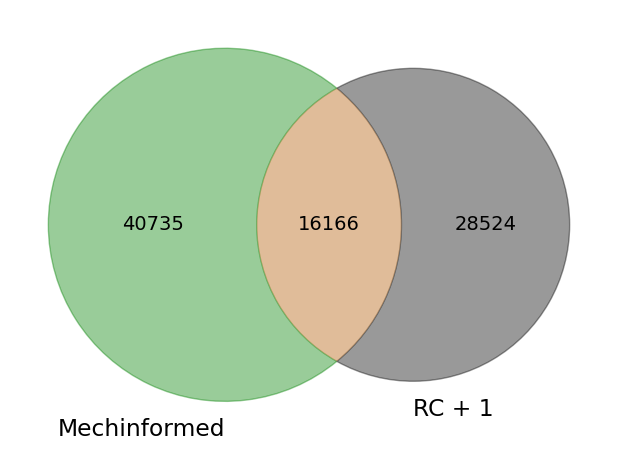

In [9]:
make_venn2(rids["Mechinferred >0.956"], rids["RC + 1"], "Mechinferred >0.956", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=1.0), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.224"], rids["RC + 1"], "Mechinferred >0.224", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.85), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.112"], rids["RC + 1"], "Mechinferred >0.112", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.6), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.039"], rids["RC + 1"], "Mechinferred >0.039", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.45), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.019"], rids["RC + 1"], "Mechinferred >0.019", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.3), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinformed"], rids["RC + 1"], "Mechinformed", "RC + 1", left_color=matplotlib.colors.to_rgba("green", alpha=1.0), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)

In [10]:
@lru_cache()
def _get_std_cid(cid: str) -> str:
    return standardize_smiles(cid)

def get_std_cids(smarts: str) -> list:
    cids = set(smarts.split('>>')[0].split('.'))
    std_cids = [_get_std_cid(cid) for cid in cids]
    return std_cids

def has_all_kcs(cids: list, kcs: pd.DataFrame = kcs) -> bool:
    for cid in cids:
        if cid not in set(kcs['id'].values):
            return False
    return True

def has_any_starter(cids: list, starters: pd.DataFrame = starters) -> bool:
    for cid in cids:
        if cid in set(starters['smiles'].values):
            return True
    return False

In [11]:
rxn_df = rxn_df.drop_duplicates(subset=["id"])
feasible_rids = set(rxn_df.loc[rxn_df["dxgb_label"] == 1, "id"].values)
mechinferred_only_feas = (rids["Mechinferred >0.019"] - rids["RC + 1"]) & feasible_rids
mechinformed_only_feas = (rids["Mechinformed"] - rids["RC + 1"]) & feasible_rids
rxn_df = rxn_df[rxn_df['id'].isin(mechinferred_only_feas | mechinformed_only_feas)]
rxn_df['cids'] = rxn_df['smarts'].apply(get_std_cids)
rxn_df['has_starter'] = rxn_df['cids'].apply(has_any_starter)
# rxn_df = rxn_df[rxn_df['has_starter']]
# rxn_df['has_all_kcs'] = rxn_df['cids'].apply(has_all_kcs)
rxn_df['smarts_len'] = rxn_df['smarts'].apply(len)
rxn_df = rxn_df.sort_values(by='smarts_len', ascending=True)

In [12]:
i = 0

Rcb3a21e64aba60590a26e7bb7db1394b3ed525020f95d56b729b09317ab1299b
1.0000000000000002
Predicted: 


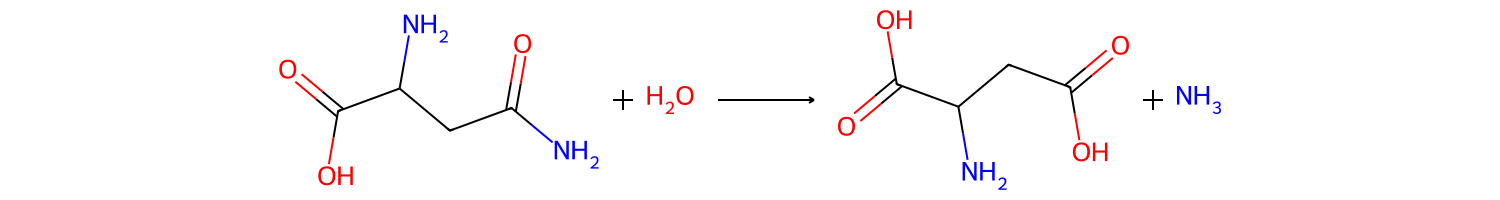

Known: 


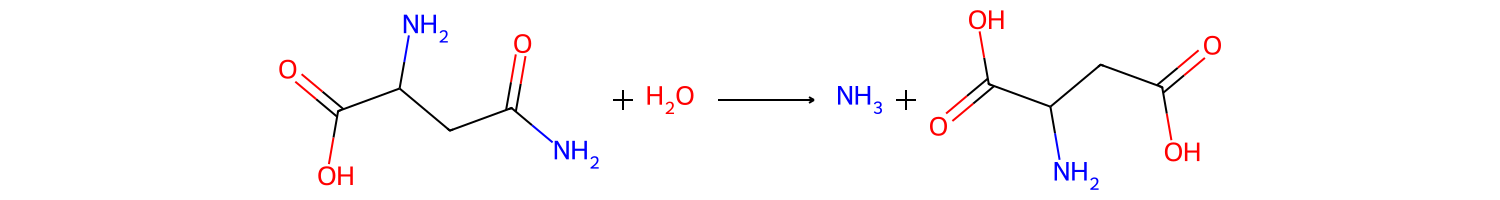

In [13]:
_df = rxn_df.loc[rxn_df['rule_set'] == 'mechinferred_dt_019']
row = _df.iloc[i]
print(row['id'])
print(row['max_rxn_sim'])
print("Predicted: ")
display(SVG(
    draw_reaction(row['smarts'])
))
print("Known: ")

display(SVG(
    draw_reaction(row['nearest_analogue'])
))
i += 1

In [14]:


meche_of_i = [
    "R607da3605a8c2c0ca5cf8a55a3028e70c56eb252bc64d9dc478a1309cdbe5a68",
    "R105430473f7e83e9c261ae4bbb11132449b4bb6e36fbfb2abbcd4691e6fc22f4",
    "Rfa361a0ffcf58a04de1da0b0bed126c071706a29c9cb861bc87d2e077329cfdd",
    "R659626b01ce367d284540ceb4a20b9e6dccb1635895ecc355ec6723a8b8a4a6f",
    "R38a5a2f52362322977d8616df77396d9b8d71038708c87474b9a0115d565527b",
    "R51da24abce71b42b71575d4ffebbfaa573fbbe244a39f492f07141b6c52b092b",
    "R3007e0ae42b004f38a2d12cfb8ce25f4bd5132eba1c4de0cf83fcdddd40e9262",
    "R64bf9f614aa56f6e18dbf59452957bba09234478b70a0a5b82dc0f5ea9fab9a8",
    "R904f1bd5c7077ffd2a1aec236cfe8cafc9ec586d2a5635e3751820fdf9042003",
]

mecho_of_i = [
    "R5d32cadbcf8d910bd4438f146ead95b5609468b373d5d3e9e9ceef678c87520b",
    "R0b5ecf2f087ff3c2cf7d498b965921c9757eb3c934d60cd7ca7096f36d6c5d6d",
    "R4c85762b1852775e6adde974f0d4a47813a3f4d73a912e39511d60b6528c282b",
    "R89c40cddab7c01f97c0cccd9f09758e13bedd3cae2de6572d1ebd6e287cd1cba",
    "Rca0983ae4923aa66d97ad7ad23e5dec37137aef33fabb18e26fd184df690685f",
    "R348693c8eeedbf4274d265839f1e9ee2137631f115387d3906b5a9b37ea5ddd1",
]

R607da3605a8c2c0ca5cf8a55a3028e70c56eb252bc64d9dc478a1309cdbe5a68
0.9174698042719671
Predicted: 


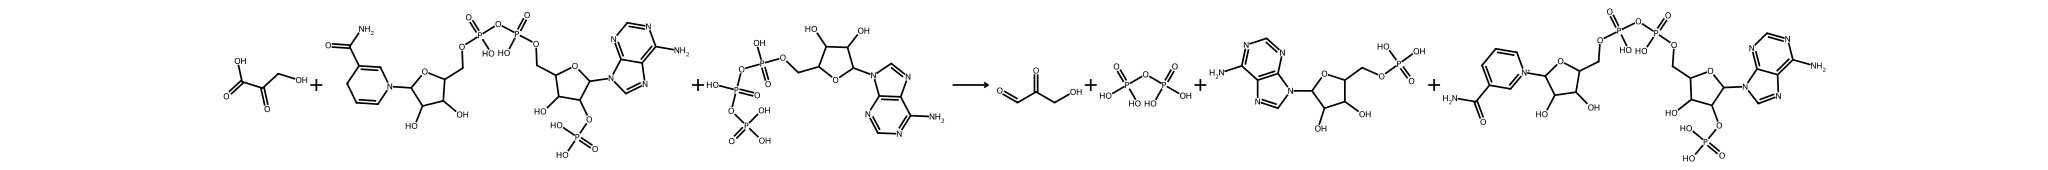

Known: 


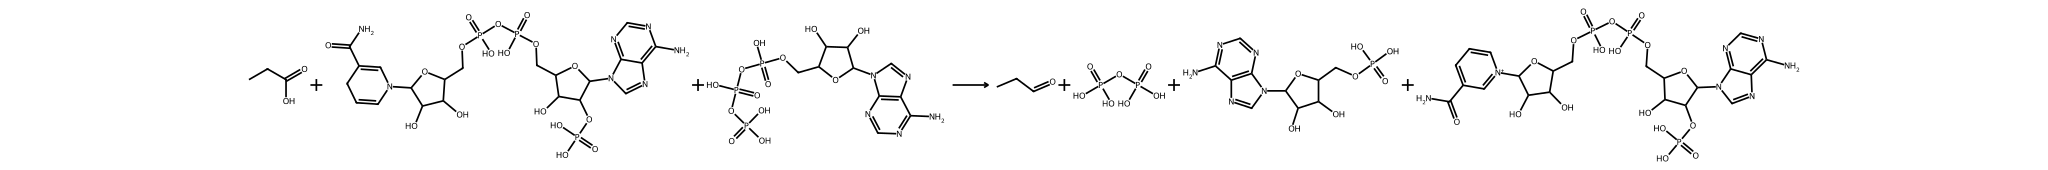

R105430473f7e83e9c261ae4bbb11132449b4bb6e36fbfb2abbcd4691e6fc22f4
0.6674238124719146
Predicted: 


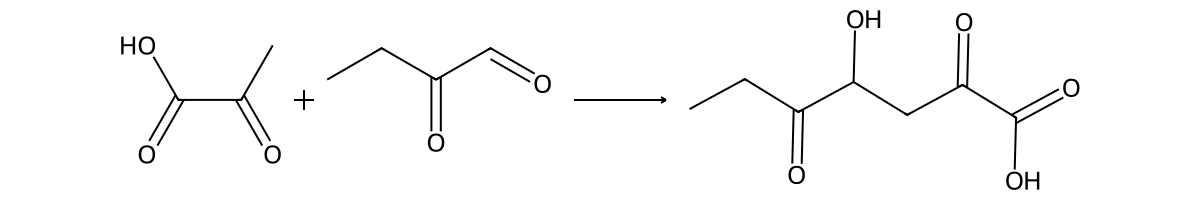

Known: 


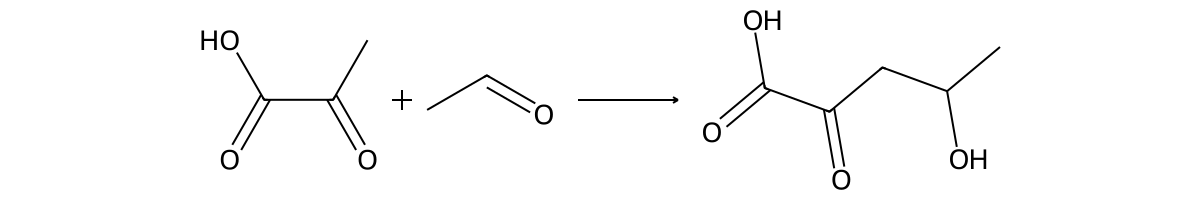

Rfa361a0ffcf58a04de1da0b0bed126c071706a29c9cb861bc87d2e077329cfdd
0.9714285714285714
Predicted: 


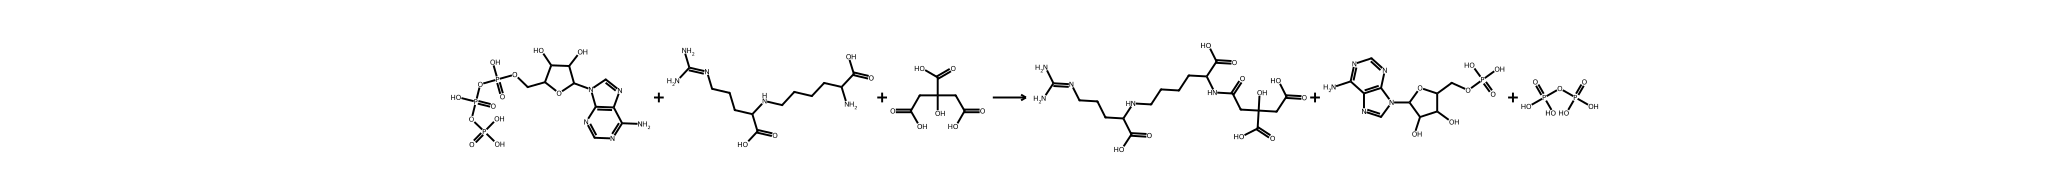

Known: 


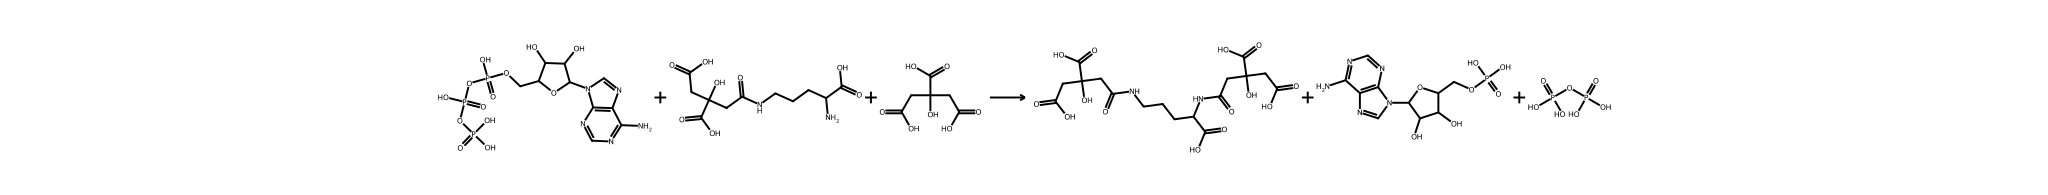

R659626b01ce367d284540ceb4a20b9e6dccb1635895ecc355ec6723a8b8a4a6f
0.9566222088265397
Predicted: 


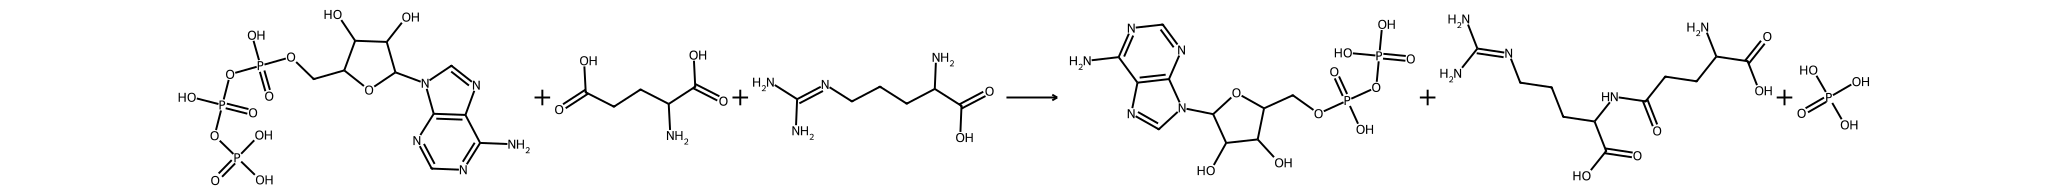

Known: 


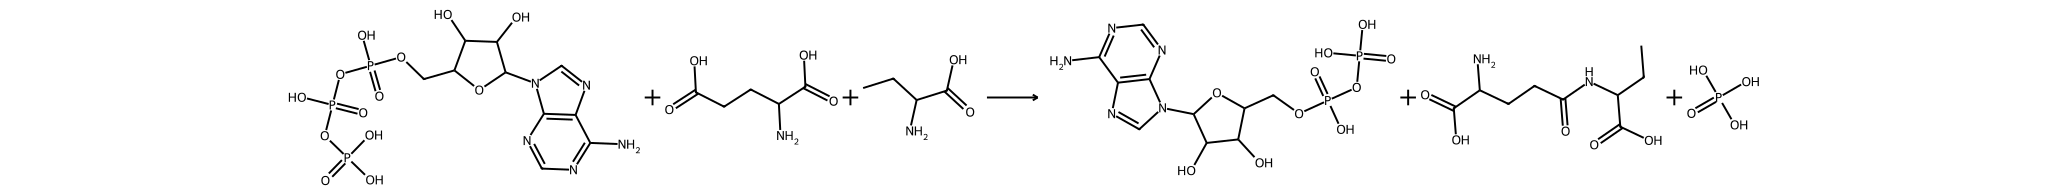

R38a5a2f52362322977d8616df77396d9b8d71038708c87474b9a0115d565527b
0.9389710680668849
Predicted: 


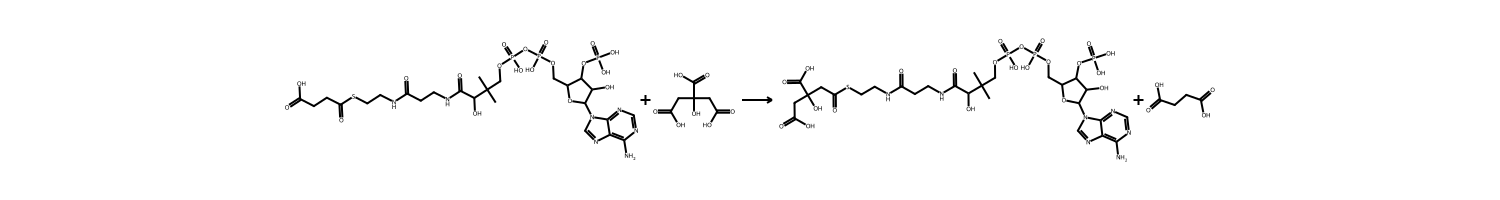

Known: 


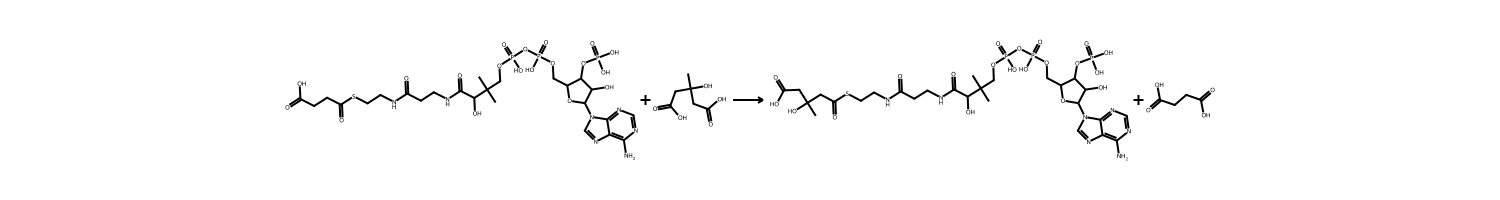

R51da24abce71b42b71575d4ffebbfaa573fbbe244a39f492f07141b6c52b092b
0.9090909090909091
Predicted: 


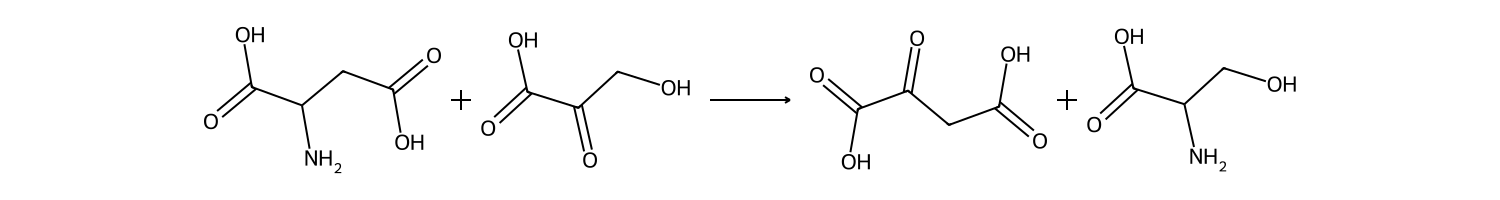

Known: 


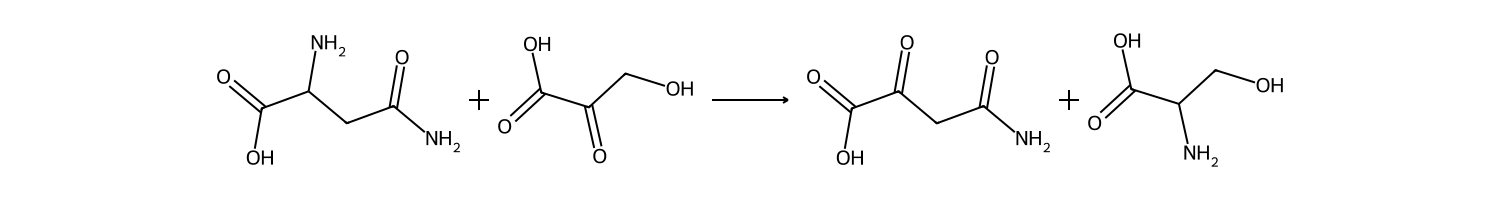

R3007e0ae42b004f38a2d12cfb8ce25f4bd5132eba1c4de0cf83fcdddd40e9262
0.7409585736349483
Predicted: 


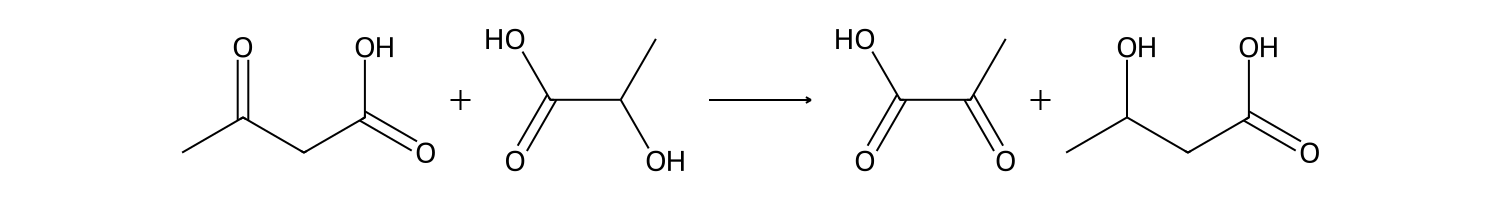

Known: 


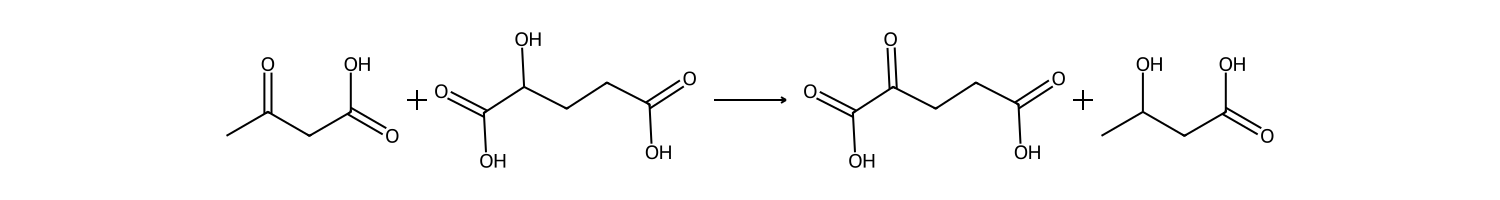

R64bf9f614aa56f6e18dbf59452957bba09234478b70a0a5b82dc0f5ea9fab9a8
0.6831300510639733
Predicted: 


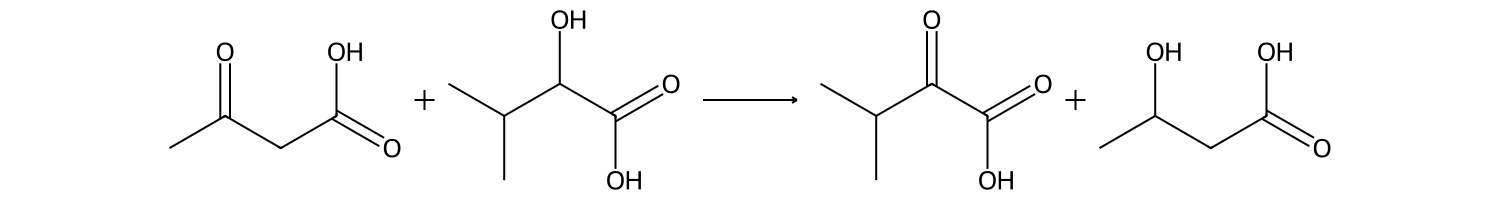

Known: 


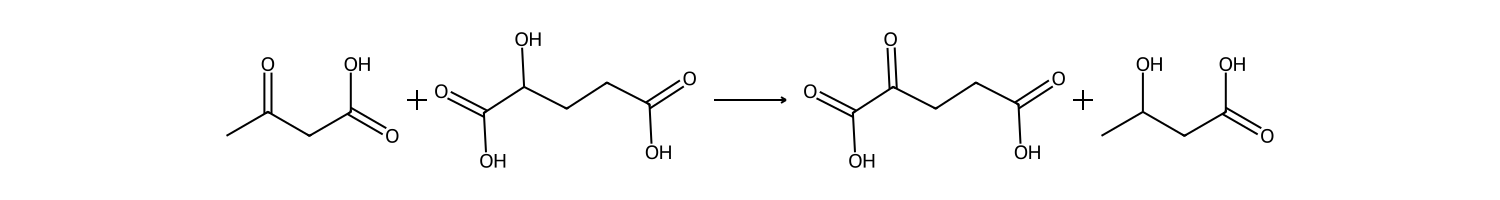

R904f1bd5c7077ffd2a1aec236cfe8cafc9ec586d2a5635e3751820fdf9042003
0.6831300510639733
Predicted: 


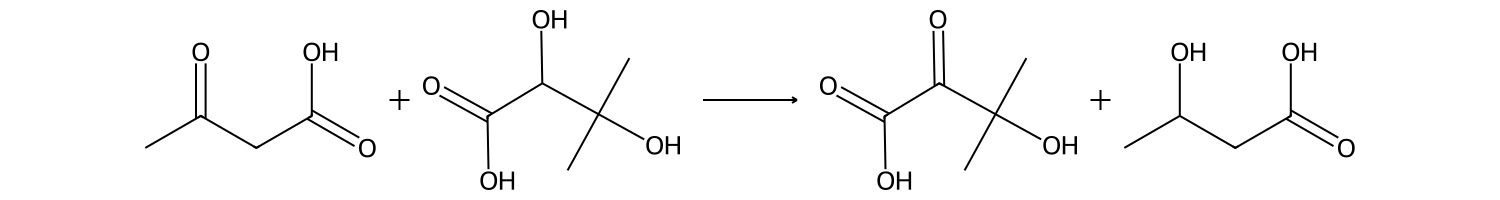

Known: 


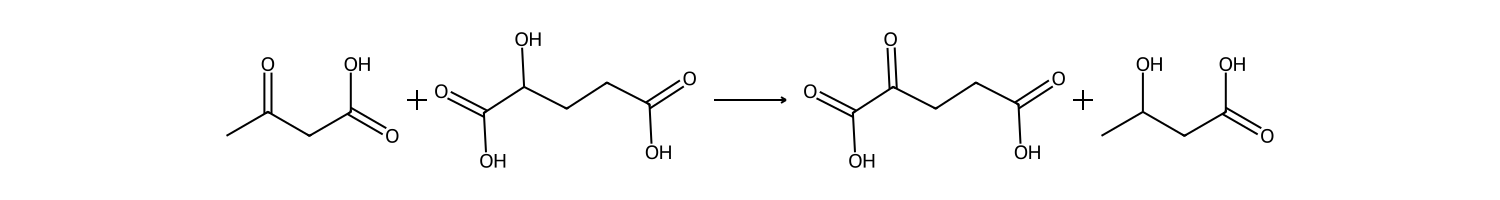

In [19]:
for rid in meche_of_i:
    _df = rxn_df.loc[rxn_df['id'] == rid]
    row = _df.iloc[0]
    print(row['id'])
    print(row['max_rxn_sim'])
    pimg = draw_reaction(row['smarts'], draw_options={'useBWAtomPalette': None})
    print("Predicted: ")
    display(SVG(pimg))
    print("Known: ")
    kimg = draw_reaction(row['nearest_analogue'], draw_options={'useBWAtomPalette': None})
    display(SVG(kimg))

    id_pref = rid[:7]

    with open(Path(cfg.figures) / "illustrative_mech_only_pred_rxns" / f"mechinfer_pred_{id_pref}.svg", "w") as f:
        f.write(pimg)

    with open(Path(cfg.figures) / "illustrative_mech_only_pred_rxns" / f"mechinfer_known_{id_pref}.svg", "w") as f:
        f.write(kimg)

R5d32cadbcf8d910bd4438f146ead95b5609468b373d5d3e9e9ceef678c87520b
0.5714285714285714
Predicted: 


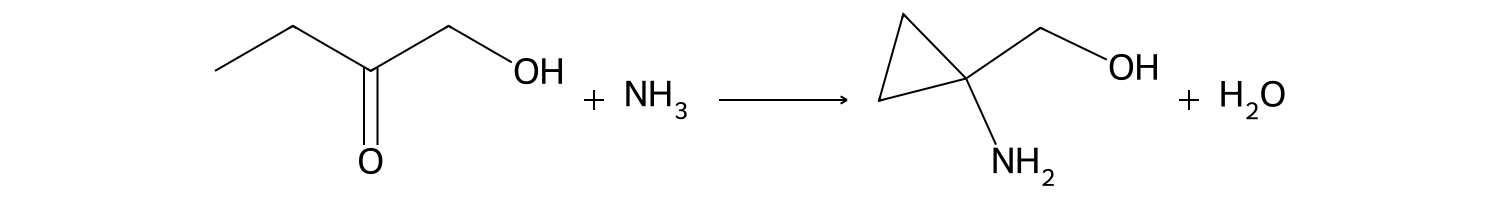

Known: 


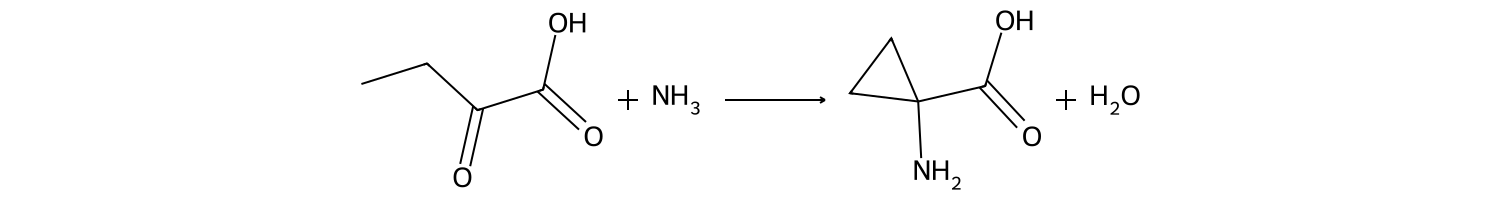

R0b5ecf2f087ff3c2cf7d498b965921c9757eb3c934d60cd7ca7096f36d6c5d6d
0.6285393610547089
Predicted: 


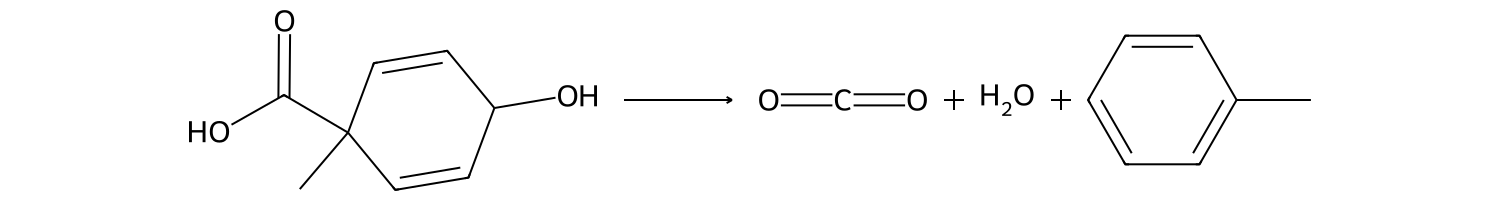

Known: 


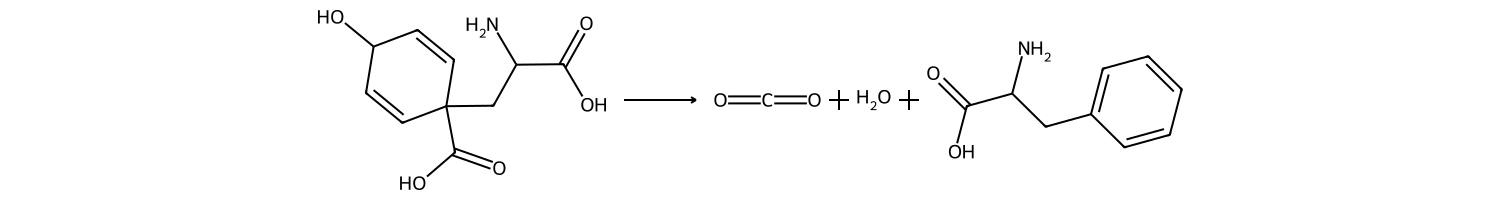

R4c85762b1852775e6adde974f0d4a47813a3f4d73a912e39511d60b6528c282b
0.47058823529411764
Predicted: 


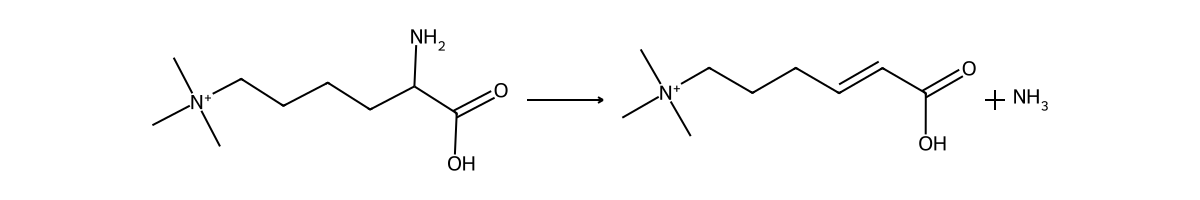

Known: 


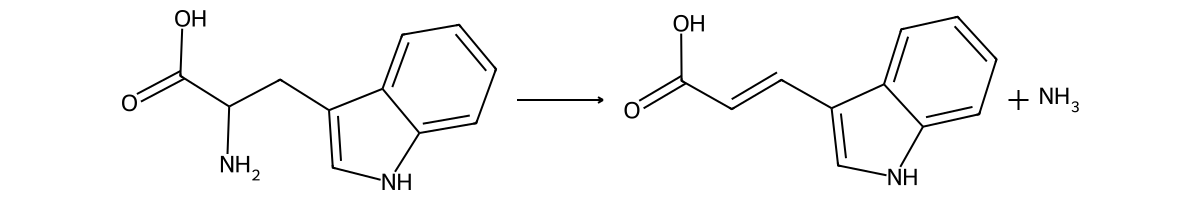

R89c40cddab7c01f97c0cccd9f09758e13bedd3cae2de6572d1ebd6e287cd1cba
0.5669467095138409
Predicted: 


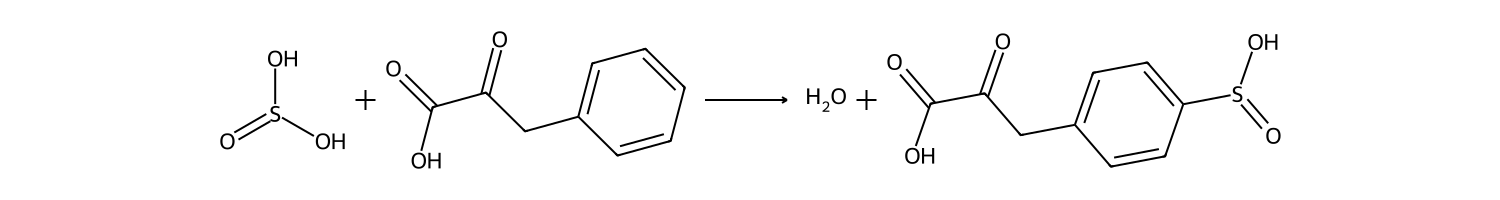

Known: 


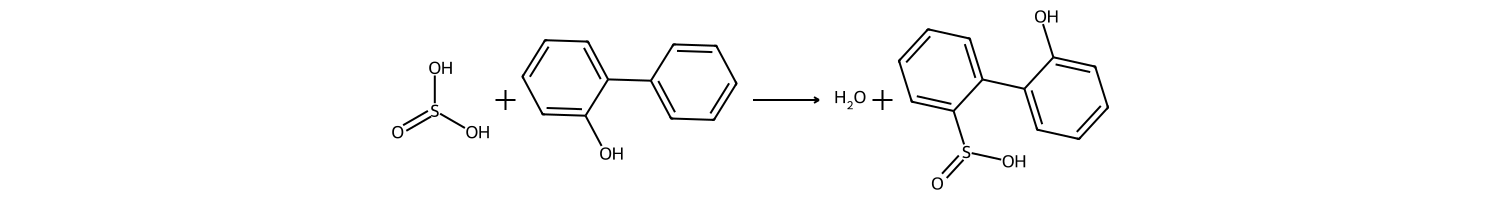

Rca0983ae4923aa66d97ad7ad23e5dec37137aef33fabb18e26fd184df690685f
0.5460189062319482
Predicted: 


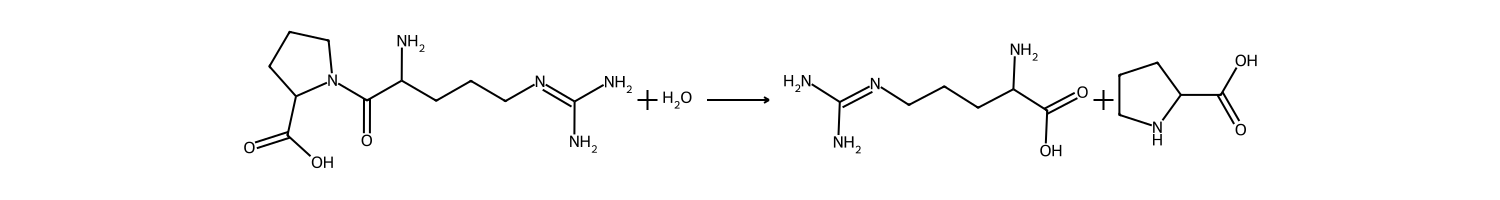

Known: 


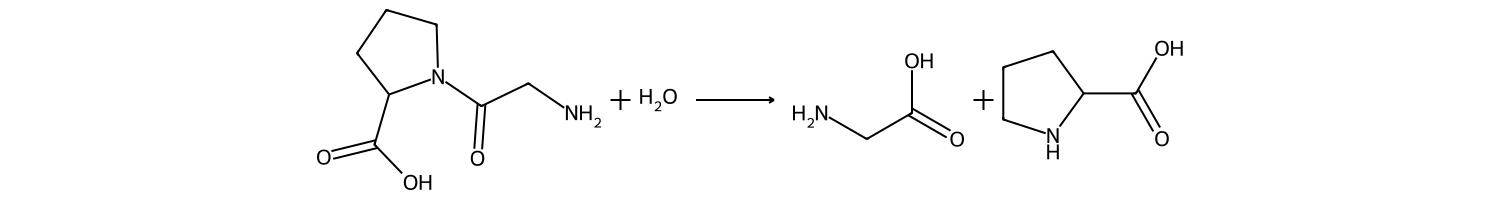

R348693c8eeedbf4274d265839f1e9ee2137631f115387d3906b5a9b37ea5ddd1
0.6666666666666667
Predicted: 


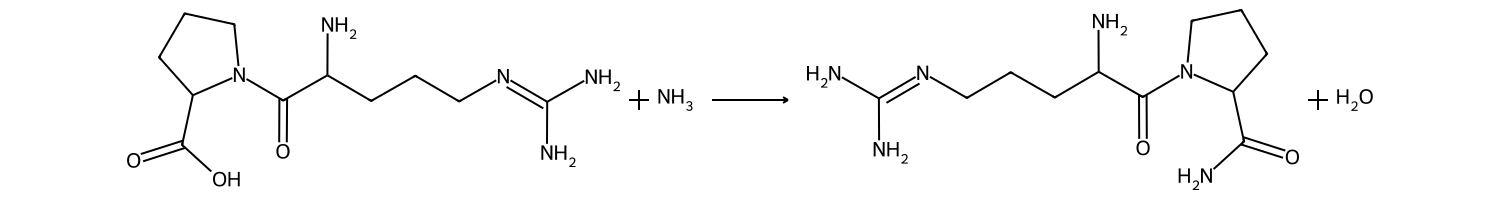

Known: 


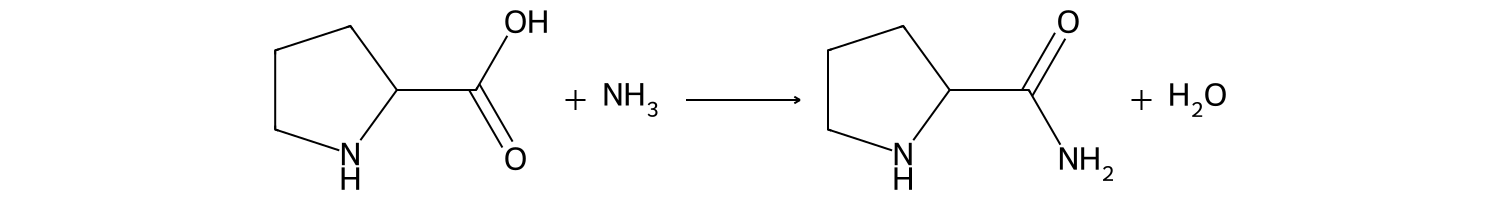

In [20]:
for rid in mecho_of_i:
    _df = rxn_df.loc[rxn_df['id'] == rid]
    row = _df.iloc[0]
    print(row['id'])
    print(row['max_rxn_sim'])
    pimg = draw_reaction(row['smarts'], draw_options={'useBWAtomPalette': None})
    print("Predicted: ")
    display(SVG(pimg))
    print("Known: ")
    kimg = draw_reaction(row['nearest_analogue'], draw_options={'useBWAtomPalette': None})
    display(SVG(kimg))

    id_pref = rid[:7]

    with open(Path(cfg.figures) / "illustrative_mech_only_pred_rxns" / f"mechinform_pred_{id_pref}.svg", "w") as f:
        f.write(pimg)

    with open(Path(cfg.figures) / "illustrative_mech_only_pred_rxns" / f"mechinform_known_{id_pref}.svg", "w") as f:
        f.write(kimg)